/Users/josebraz/opt/anaconda3/lib/python3.9/site-packages/pysal/explore/segregation/network/network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(


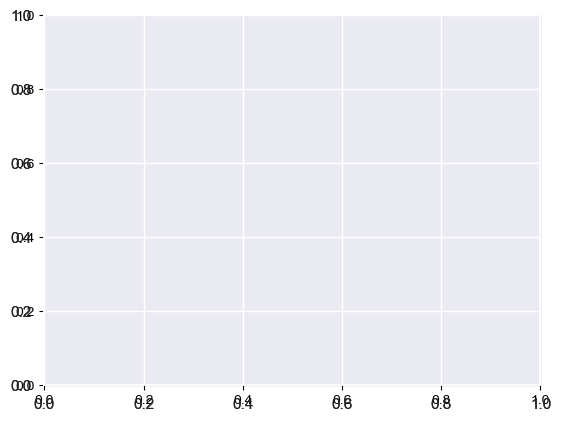

In [1]:
import numpy as np
import geopandas as gpd
import shapely

from explore import *
from utils import *

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import contextily as cx

# dados de https://appeears.earthdatacloud.nasa.gov

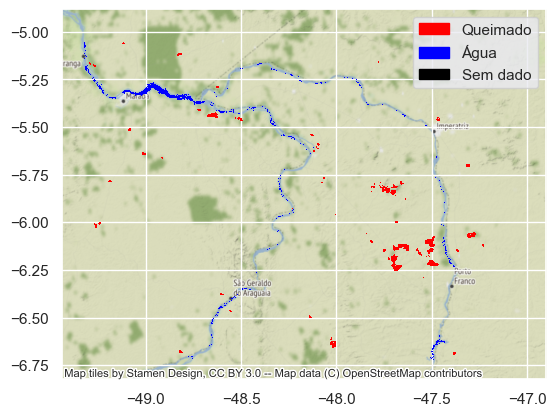

In [5]:
burn_colors = {
    -2: (0.0, 0.0, 1.0, 1.0),
    -1: (0.0, 0.0, 0.0, 1.0),
    0: (0.0, 0.0, 0.0, 0.0)
}
for i in range(1, 367):
    burn_colors[i] = (1.0, 0.0, 0.0, 1.0)

legend_handler = [
    mpatches.Patch(color=burn_colors[1], label='Queimado'),
    mpatches.Patch(color=burn_colors[-2], label='Água'),
    mpatches.Patch(color=burn_colors[-1], label='Sem dado'),
]

def show_nasa_burn_area(fp: str, **kwargs):
    ax = kwargs.get('ax')
    if ax == None:
        fig, ax = plt.subplots(1, 1)
    ax.legend(handles=legend_handler)
    data = read_gdf_from_tiff(fp)
    color = data['value'].map(burn_colors)
    data.plot(color=color, ax=ax, linewidth=0, **kwargs)
    cx.add_basemap(ax, crs=data.crs.to_string())

show_nasa_burn_area('tiff/MCD64A1.061_Burn_Date_doy2022213_aid0001.tif')

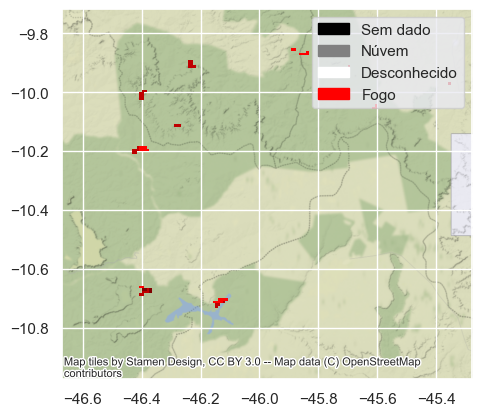

In [6]:
fire_colors = {
    0: (0.0, 0.0, 0.0, 1.0), # 0 = missing input data
    1: (0.0, 0.0, 0.0, 1.0), # 1 = obsolete; not used since Collection 1
    2: (0.0, 0.0, 0.0, 1.0), # 2 = other reason
    3: (0.0, 0.0, 0.0, 0.0), # 3 =  non-fire water pixel
    4: (0.5, 0.5, 0.5, 1.0), # 4 =  cloud
    5: (0.0, 0.0, 0.0, 0.0), # 5 =  non-fire land pixel
    6: (1.0, 1.0, 1.0, 1.0), # 6 =  unknown (land or water)
    7: (0.5, 0.0, 0.0, 1.0), # 7 =  fire
    8: (0.75, 0.0, 0.0, 1.0), # 8 =  fire
    9: (1.0, 0.0, 0.0, 1.0), # 9 =  fire
}

fire_legend_handler = [
    mpatches.Patch(color=fire_colors[0], label='Sem dado'),
    mpatches.Patch(color=fire_colors[4], label='Núvem'),
    mpatches.Patch(color=fire_colors[6], label='Desconhecido'),
    mpatches.Patch(color=fire_colors[9], label='Fogo'),
]

def show_active_fire(fp: str, **kwargs):
    ax = kwargs.get('ax')
    if ax == None:
        fig, ax = plt.subplots(1, 1)
    ax.legend(handles=fire_legend_handler)
    data = read_gdf_from_tiff(fp)
    color = data['value'].map(fire_colors)
    data.plot(color=color, ax=ax, linewidth=0, **kwargs)
    cx.add_basemap(ax, crs=data.crs.to_string())

show_active_fire('tiff/MYD14A2.061_FireMask_doy2022209_aid0001.tif')

In [3]:

def evaluate_gpd(reference: gpd.GeoDataFrame, other: gpd.GeoDataFrame,
                 reference_value_column: str = 'value', 
                 other_value_column: str = 'value'):
    """
    | other \ reference | queimada | não queimada |
    |-------------------|----------|--------------|
    |     queimada      |    TP    |      FP      |
    |   não queimada    |    FN    |      TN      |
    |-------------------|----------|--------------|
    """
    original_geometry = other['geometry']
    other['geometry'] = other.representative_point()
    join_gpd = gpd.sjoin(reference, other, predicate="contains", lsuffix='reference', rsuffix='other')
    other['geometry'] = original_geometry
    
    same_names = reference_value_column == other_value_column
    burned_reference = np.array(join_gpd[reference_value_column + ('_reference' if same_names else '')])
    burned_other = np.array(join_gpd[other_value_column + ('_other' if same_names else '')])
    unburned_reference = np.array(1.0 - join_gpd[reference_value_column + ('_reference' if same_names else '')])
    unburned_other = np.array(1.0 - join_gpd[other_value_column + ('_other' if same_names else '')])

    def calculate_same(array1, array2):
        min_array = np.array([array1, array2]).min(axis=0)
        normalized = min_array
        normalized[np.isnan(normalized)] = 0.0
        return normalized.sum()
    
    def calculate_diff(array1, array2):
        temp1 = array1[array1 > array2]
        temp2 = array2[array1 > array2]
        diff = (temp1 - temp2)
        return diff.sum()

    TP = calculate_same(burned_reference, burned_other)
    FN = calculate_diff(burned_reference, burned_other)
    FP = calculate_diff(burned_other, burned_reference)
    TN = calculate_same(unburned_reference, unburned_other)

    ACC = (TP + TN) / (TP + FP + FN + TN)
    TPR = TP / (TP + FN) # true positive rate
    TNR = TN / (TN + FP) # true negative rate
    PPV = TP / (TP + FP) # positive predictive value 
    NPV = TN / (TN + FN) # negative predictive value
    CE = FN / (FN + TP)  # false negative rate (erro de comissão)
    OE = FP / (FP + TP)  # false discovery rate
    B  = (TP + FP) / (TP + FN)
    DC = 2 * TP / (2 * TP + FP + FN)

    return { 'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN,
             'ACC': ACC, 'CE': CE, 'OE': OE, 'B': B, 
             'DC': DC, 'TPR': TPR, 'TNR': TNR, 'PPV': PPV, 
             'NPV': NPV }


{'TP': 1.8, 'FP': 0.0, 'FN': 0.19999999999999998, 'TN': 482.0, 'ACC': 0.9995867768595041, 'CE': 0.09999999999999999, 'OE': 0.0, 'B': 0.9, 'DC': 0.9473684210526315, 'TPR': 0.9, 'TNR': 1.0, 'PPV': 1.0, 'NPV': 0.9995852343425965}


<Axes: >

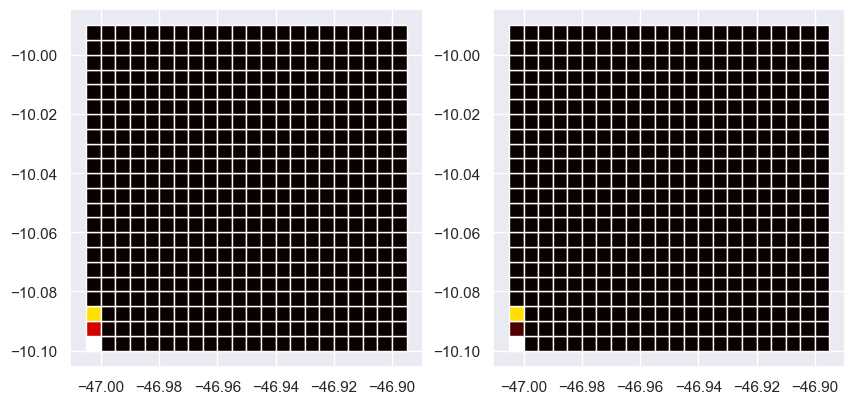

In [14]:
xmin, xmax, ymin, ymax = -47, -46.90, -10.1, -10
quadrat_width = 0.005
bounds = shapely.geometry.box(xmin, ymin, xmax, ymax)
gdf1: gpd.GeoDataFrame = grid_gdf(normalized, bounds, quadrat_width)
gdf2: gpd.GeoDataFrame = grid_gdf(normalized, bounds, quadrat_width)

value1 = np.zeros(len(gdf1))
value1[0] = 1.0
value1[1] = 0.3
value1[2] = 0.7

value2 = np.zeros(len(gdf2))
value2[0] = 1.0
value2[1] = 0.1
value2[2] = 0.7

gdf1['value'] = value1
gdf2['value'] = value2

print(evaluate_gpd(gdf1, gdf2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 23))

gdf1.plot(ax=ax1, column='value', cmap='hot')
gdf2.plot(ax=ax2, column='value', cmap='hot')

In [4]:
df = read_burn_df()

In [97]:
def compare_aqm_and_explore(aqm_gdf: gpd.GeoDataFrame, explore_df: pd.DataFrame, 
                            xmin = None, xmax = None, ymin = None, ymax = None, 
                            quadrat_width = 0.005, ax1: plt.Axes = None, 
                            ax2: plt.Axes = None, normatized: bool = False):
    if ax1 is None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10), sharey=True, sharex=True)
        fig.tight_layout()

    bounds = None if xmin is None else shapely.geometry.box(xmin, ymin, xmax, ymax)
    normalized = aqm_gdf if normatized else normalize_gdf(aqm_gdf, bounds, quadrat_width)
    normalized[normalized['value'] > 0].plot(column='value', ax=ax1, cmap='hot', linewidth=0.0, legend=True)
    cx.add_basemap(ax1, crs=normalized.crs.to_string())

    data_temp = explore_df if xmin is None else sub_space(explore_df, ymin, ymax, xmin, xmax)
    explorer = SatellitesExplore(data_temp, quadrat_width=quadrat_width, 
                                 burned_area_calc=polinomial_burned_area_calc(1, 10, 2),
                                 min_area_percentage=0.02,
                                 threshold_satellite=1)
    # explorer.show_satellites_areas(ax=ax2)
    explorer.show_satellites_quads_areas(ax=ax2, linewidth=0, cmap='hot')
    cx.add_basemap(ax2, crs=explorer.dataframe.crs.to_string())

    burned = explorer.get_burned_areas()[explorer.get_burned_areas()['burned_factor'] > 0.0]
    temp = gpd.GeoDataFrame(
        { 'value': burned['burned_factor'], 'geometry': burned['geometry'] },
        crs = burned.crs
    )
    return evaluate_gpd(normalized, temp)

In [92]:
def compare_aqm_and_explore_multiple(aqm_gdfs: list[gpd.GeoDataFrame], explore_dfs: list[pd.DataFrame], 
                                     xmin = None, xmax = None, ymin = None, ymax = None, 
                                     quadrat_width = 0.005, normatized: bool = False):
    size = len(aqm_gdfs)
    fig, axs = plt.subplots(size, 2, figsize=(25, size * 10), sharey=True, sharex=True)
    fig.tight_layout()
    for index, (aqm_file, explore_df) in enumerate(zip(aqm_gdfs, explore_dfs)):
        (ax1, ax2) = axs[index]
        data = compare_aqm_and_explore(aqm_file, explore_df, xmin, xmax, ymin, ymax, 
                                       quadrat_width, ax1, ax2, normatized)
        time = explore_df.iloc[0]['datahora']
        ax1.set_title(f'Time: {time}')
        ax2.set_title(f"""ACC = {int(data['ACC'] * 100)}%, CE = {int(data['CE'] * 100)}%, OE = {int(data['OE'] * 100)}%""")

In [87]:
path, row, quadrat_width = 221, 67, 0.005
geometry = get_landsat_geometry(path, row)
aqm_gdfs = [normalize_gdf(gpd.read_file('tiff/LS8_AQM_221_067_20210703_0107'), geometry, quadrat_width), 
            normalize_gdf(gpd.read_file('tiff/LS8_AQM_221_067_20210719_0107'), geometry, quadrat_width), 
            normalize_gdf(gpd.read_file('tiff/LS8_AQM_221_067_20210804_0107'), geometry, quadrat_width), 
            normalize_gdf(gpd.read_file('tiff/LS8_AQM_221_067_20210820_0107'), geometry, quadrat_width)]
explore_dfs = [sub_space_by_landsat(df.query("'2021-06-18 00:00:00-03:00' < datahora < '2021-07-03 23:59:59-03:00'"), path, row),
               sub_space_by_landsat(df.query("'2021-07-03 00:00:00-03:00' < datahora < '2021-07-19 23:59:59-03:00'"), path, row),
               sub_space_by_landsat(df.query("'2021-07-19 00:00:00-03:00' < datahora < '2021-08-04 23:59:59-03:00'"), path, row), 
               sub_space_by_landsat(df.query("'2021-08-05 00:00:00-03:00' < datahora < '2021-08-20 23:59:59-03:00'"), path, row)]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


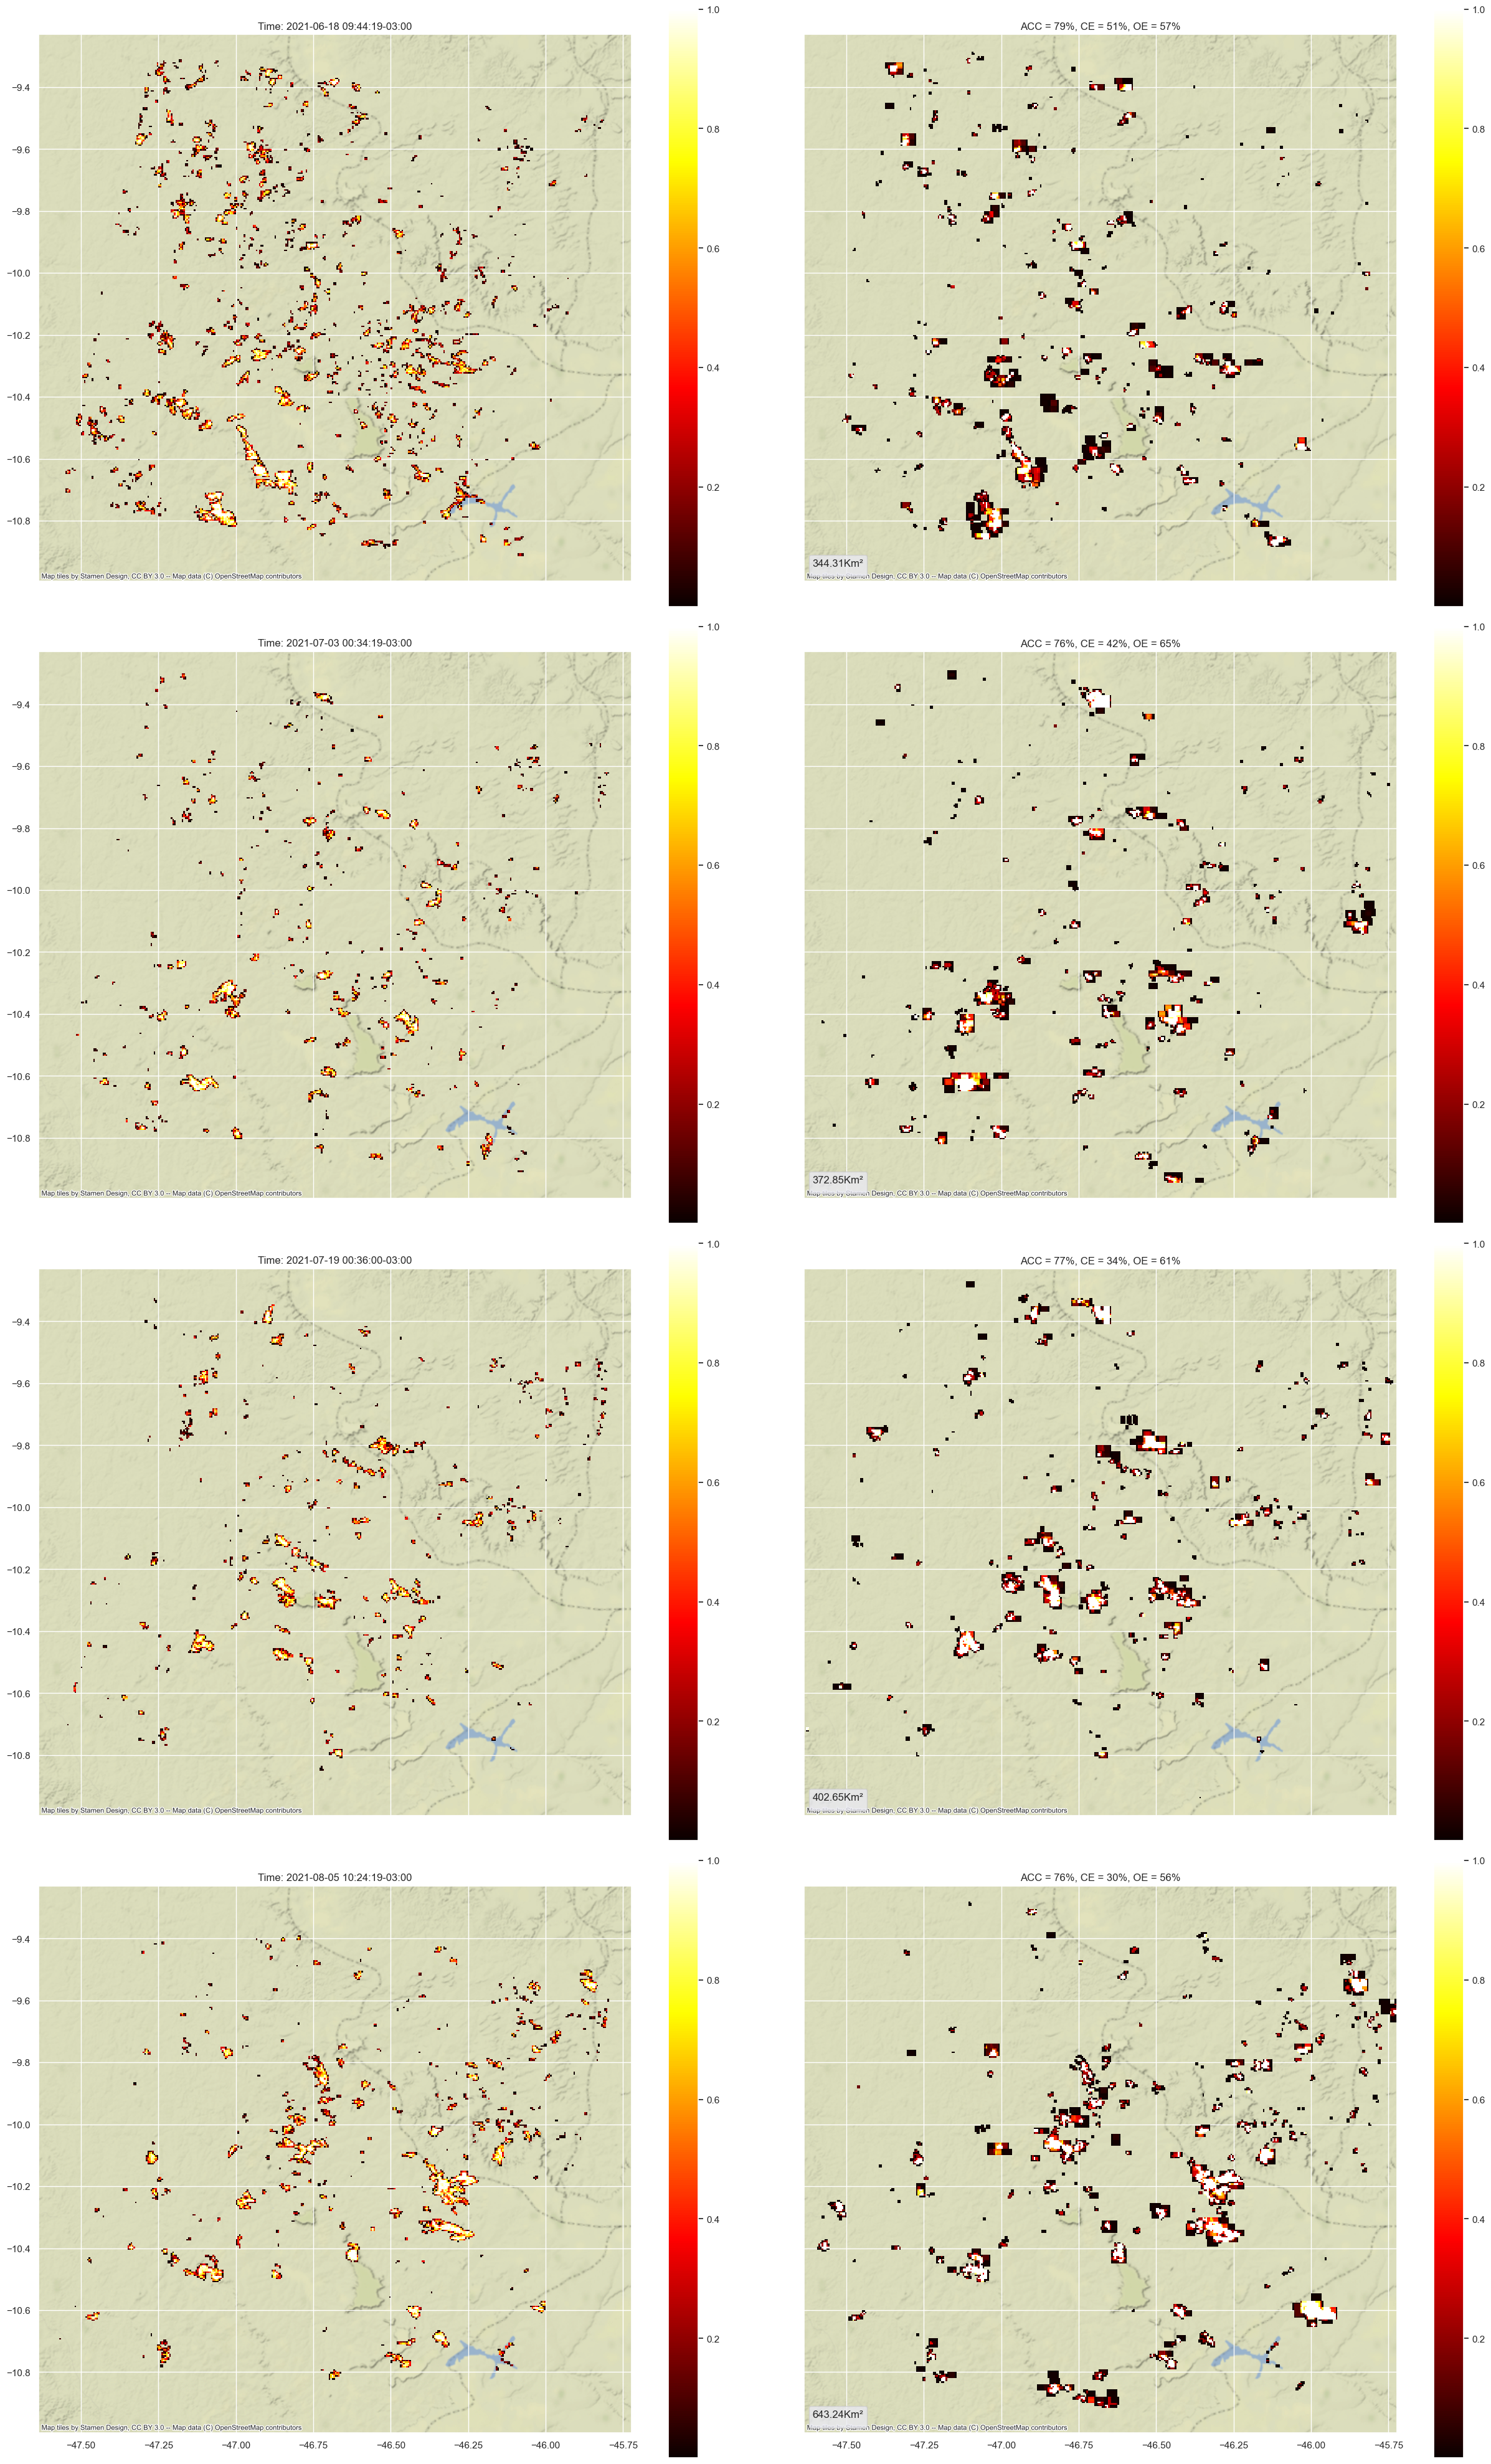

In [94]:
compare_aqm_and_explore_multiple(aqm_gdfs, explore_dfs, quadrat_width=quadrat_width, normatized=True)